# Compressive sensing: tomography reconstruction with L1 prior (Lasso)
(压缩感知：使用 L1 先验 (Lasso) 进行CT重建)  
[原文连接](https://scikit-learn.org/stable/auto_examples/applications/plot_tomography_l1_reconstruction.html#sphx-glr-auto-examples-applications-plot-tomography-l1-reconstruction-py)

## CT扫描、投影

参考：
[Youtube- CT Reconstruction: (Radon transform, Fourier Slice Theorem, & Convolution Backprojection) ](https://www.youtube.com/watch?v=65LMqRUaGo0)  
[Looking through Objects - How Tomography Works! ](https://youtu.be/f0sxjhGHRPo?si=ygAn-mykpmx48y9W)

投影的理解，图像大小为$4*4$。   
一个角度的投影就是 旋转点再原坐标轴（离散）的权重分配。  
因为点旋转后落不到离散x上，所以通过插值分配。  
点积分到旋转轴上， 和旋转点积分到原坐标轴上， 是等价的。  


In [2]:
%matplotlib inline

## 1. 生成2值图像

In [1]:
import matplotlib.pyplot as plt
from matplotlib.path import Path
import numpy as np
def generate_synthetic_data(size):
    """ 生成一个2值图像: 包含很多圆圈圈
    """
    rs = np.random.RandomState(42)
    n_points = 36 # 着36个1点
    x,y = np.ogrid[0:size, 0:size] # 网格行列索引，
    mask_outer = (x - size/2)**2 + (y - size/2)**2 < (size/2)**2 # 圆布尔数组，半径为size/2 
    mask = np.zeros((size,size)) # 空白画布
    points = size*rs.rand(2, n_points) # 生成2行36列， 每列为一个点， 值在[0,size)
    mask[(points[0]).astype(int), points[1].astype(int)] = 1 # 标记这些点
    mask = ndimage.gaussian_filter(mask,sigma= size/n_points) # 把这些点晕开，1晕开成周围的0.xx值
    res = np.logical_and(mask>mask.mean(), mask_outer) # 取模糊后大于图像均值的点，且在园内的。 为布尔数组
    return np.logical_xor(res,ndimage.binary_erosion(res)) # 只留下轮廓边界， 为布尔数组，布尔也可以直接和0，1表示，

def generate_synthetic_shape_data(size, shape):
    """ 生成一个二值图像：支持圆形、矩形、三角形
    Parameters:
        size (int): 图像大小 (size x size)
        shape (str): 形状类型 ["circle", "square", "triangle"]
    Returns:
        np.ndarray: 二值图像
    """
    
    img = np.zeros((size, size), dtype=np.uint8) 

    if shape == "circle":
        x, y = np.ogrid[:size, :size]  # 生成网格
        center = size // 2
        radius = size // 3  # 半径
        mask = (x - center) ** 2 + (y - center) ** 2 <= radius ** 2
        img[mask] = 1

    elif shape == "square":
        margin = size // 4
        img[margin:-margin, margin:-margin] = 1  # 中心填充

    elif shape == "triangle":
        # 定义三角形顶点
        vertices = np.array([
            [size // 2, size // 4],  # 顶点
            [size // 4, 3 * size // 4],  # 左下角
            [3 * size // 4, 3 * size // 4]  # 右下角
        ])
        x, y = np.meshgrid(np.arange(size), np.arange(size))
        points = np.stack((x.ravel(), y.ravel()), axis=-1)

        # 用 Path 判断点是否在三角形内
        path = Path(vertices)
        mask = path.contains_points(points).reshape(size, size)
        img[mask] = 1

    return img

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

def generate_smiley(size=100):
    """ 生成灰度笑脸图像 """
    img = Image.new("L", (size, size), 255)  # 创建白色背景灰度图像
    draw = ImageDraw.Draw(img)
    
    # 画圆形脸（中等灰度）
    draw.ellipse((10, 10, size-10, size-10), fill=180)

    # 画眼睛（深色）
    draw.ellipse((size*0.3, size*0.3, size*0.4, size*0.4), fill=50)
    draw.ellipse((size*0.6, size*0.3, size*0.7, size*0.4), fill=50)

    # 画嘴巴（较深色）
    draw.arc((size*0.3, size*0.5, size*0.7, size*0.8), start=0, end=180, fill=50, width=5)
    
    return np.array(img)


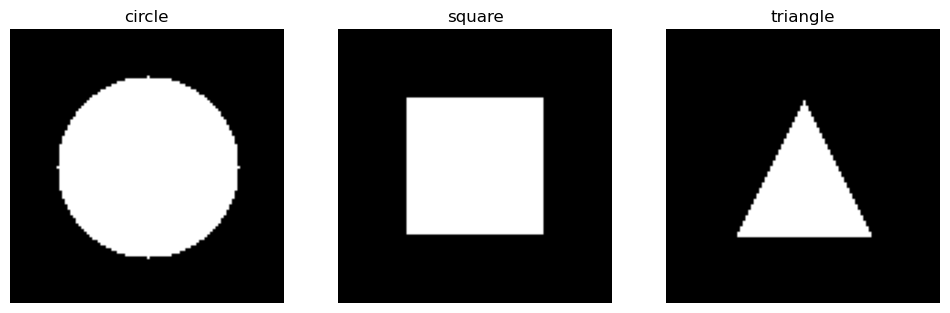

In [3]:
# 画图
shapes = ["circle", "square", "triangle"]
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for ax, shape in zip(axes, shapes):
    img = generate_synthetic_shape_data(100, shape)
    ax.imshow(img, cmap="gray")
    ax.set_title(shape)
    ax.axis("off")

## 2. 投影算子生成

In [4]:
import numpy as np
from scipy import ndimage, sparse
import pandas as pd
def _generate_center_coordinates(l_x):
    """ 生成中心网络
    """
    X,Y = np.mgrid[0:l_x, 0:l_x].astype(np.float64)
    center = l_x / 2.0
    X+= 0.5 - center
    Y+= 0.5- center
    return X,Y

def print_insert(x,indices,weights, orig):
    """
    x:原始点
    """
    print(f"PRINT INSERT size:{len(x)}, orig:{orig}")

    # 打印插值结果
    data = pd.DataFrame(
        {
            'x':x,
            'left_X':indices[:len(x)],
            'right_X':indices[len(x):],
            'left_weight':weights[:len(x)],
            'right_weight':weights[len(x):]
        }
    )
    data['verify'] = (data['left_X']+orig) *data['left_weight'] + (data['right_X']+orig) * data['right_weight']
    print(data)

def _weights(x, dx=1, orig=0):
    """ 将X坐标数组映射到离散刻度上。 计算线性插值的索引和权重
    Parameters
    ---
    orig:坐标起始点, 对X偏移， orig=1:表示网格偏移，1.5表示网格左偏移1.5 。
    dx:网格间距
    
    Returns
    ----
    [left_idx.., right_idx]
    原X坐标对应相邻索引点, 对相邻索引点的权重贡献。
    """
    x = np.ravel(x) # 输入展平为1维数组
    floor_x = np.floor((x-orig) /dx).astype(np.int64)
    alpha = (x - orig - floor_x*dx) /dx
    return np.hstack((floor_x, floor_x + 1)),np.hstack((1 - alpha, alpha))

def build_project_operator(size, n_dir):
    """ 构建投影算子（矩阵），用于将原始图像转换为投影数据
    Parameters
    ----
    size : int
        原始图像大小。size * size
    n_dir : int
        使用的投影角度数
    Returns
    -----
    p : 稀疏矩阵. n_dir *size(投影x索引) ,size**2 
    """
    X,Y = _generate_center_coordinates(size)
    angles = np.linspace(0, np.pi, n_dir, endpoint=False) # 生成投影角度.  

    data_inds,weights,camera_inds =[],[],[]

    data_unravel_indices = np.arange(size**2) # 将网格索引展开
    data_unravel_indices = np.hstack((data_unravel_indices, data_unravel_indices)) # size**2 * 2
    for i,angle in enumerate(angles): # 每个角度
        Xrot = np.cos(angle) * X - np.sin(angle)*Y  # 逆时针旋转坐标系angle度
        inds, w = _weights(Xrot,dx =1, orig=X.min()) # 投影后的网格索引，和权重 ❓为啥要对xrot便宜后再
        mask = np.logical_and(inds>=0, inds<size) # 裁剪旋转后超出边界的，即 不会对超出边界点索引进行累积。

        #print_insert(Xrot.ravel(),inds,w,X.min())
        weights += list(w[mask]) # 旋转点权重，weight_left,..wight_right;
        camera_inds+=list(inds[mask]+i*size)  # 旋转点插值left_x,..right_x。 通过+size区分不同角度
        data_inds+=list(data_unravel_indices[mask]) # 原始点索引平铺，0-size*2 
        #print(f"angle :{angle:.2f},weight:{w[mask]}, inds:{inds[mask]}, camera_inds :{inds[mask] + i*size}, data_inds:{data_unravel_indices[mask]}")
    #print(camera_inds)
    # (camera_inds,data_inds)，如参数4，3. (0,1) 表示第一个角度下，第2个网格点投影到x=0的权重。 (6,1) 表示第2个角度，第2个网格点投影到x=2的权重 
    project_operator = sparse.coo_matrix((weights,(camera_inds, data_inds))) # 稀疏矩阵存储这个： 行：投影插值x，列：原始点索引，值：权重
    return project_operator 

In [5]:
# 测试：投影算子返回
size = 4
n_dir = 3
# n_dir *size(投影x索引) ,size**2(网格索引) 
g=build_project_operator(size, n_dir)


In [6]:
df = pd.DataFrame(
    {
        'camera(Grid) X':g.row,
        'original X':g.col,
        'weight':g.data
    }
)
df['angle_idx'] = df['camera(Grid) X'] // size
df.set_index('angle_idx')

,camera(Grid) X,original X,weight
angle_idx,,,
0,0,0,1.000000
0,0,1,1.000000
0,0,2,1.000000
0,0,3,1.000000
0,1,4,1.000000
...,...,...,...
2,8,11,0.950962
2,11,12,0.049038
2,10,13,0.183013


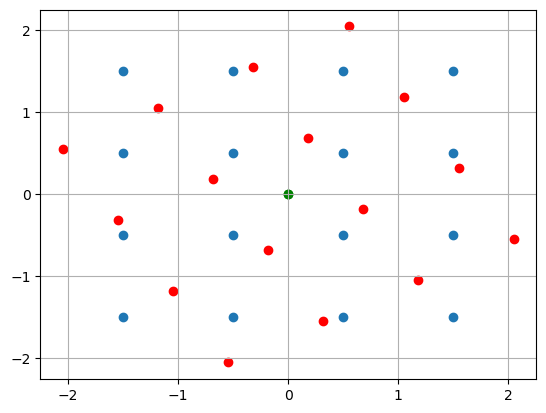

In [9]:
# 测试：绘制中心网格
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
X,Y = _generate_center_coordinates(4)

plt.scatter(0,0,color='green')
plt.scatter(X,Y)
# 扭转坐标系: angle
angle = np.pi /6
X_rot = np.cos(angle) * X - Y*np.sin(angle)
Y_rot = np.sin(angle)*X+Y*np.cos(angle)
plt.scatter(X_rot,Y_rot,color='red')
plt.scatter(0,0,color='green')
plt.grid(True)

In [7]:
import pandas as pd
def visualize_insert(x,indices,weights,orig):

    
    plt.figure(figsize=(10,3))
    plt.ylim(-0.1, 1)
    plt.yticks([])
    
    plt.axhline(0, color='black', linestyle='--')
    plt.scatter(x,np.zeros_like(x), label='original xpoint') # 
    plt.axhline(0.5, color='black', linestyle='--')
    plt.scatter(indices, np.zeros_like(indices) + 0.5, label='GRID xpoint') # 偏移可视化方便
    plt.legend()
    
    for i in range(len(x)):
        plt.plot([x[i]-orig,indices[i]],[0,0.5],linestyle='--',color='b')
        plt.plot([x[i]-orig,indices[i+len(x)]],[0,0.5],linestyle='--',color='b')
    plt.title(f"Linear Insert point,orig={orig}")

In [8]:
indices, weights = _weights(X_rot, 1, X.min())

visualize_insert(X_rot.ravel(),indices,weights,X.min())

NameError: name 'X_rot' is not defined

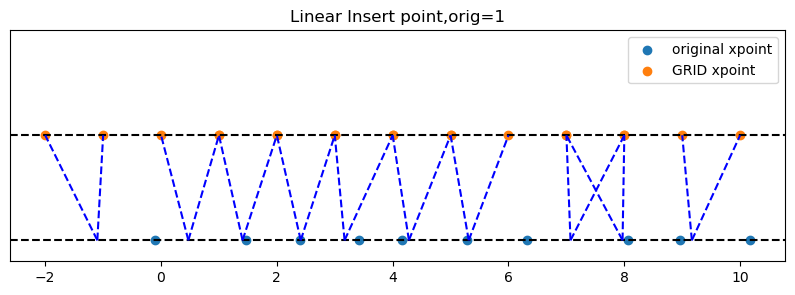

In [9]:
# 测试：权重生成
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
rng  = np.random.RandomState(42)
x = np.linspace(0, 10, 10) + rng.uniform(-0.4, 0.4, 10)  # 10个随机点
dx = 1  # 网格间距
orig = 1  # 坐标起始点
# **计算插值索引和权重**
indices, weights = _weights(x, dx, orig)

visualize_insert(x,indices,weights,orig)

In [10]:
def visualize_project(original_img, sinogram):
    directions = len(sinogram)
    plt.figure(figsize=(20,5))
    plt.subplot(1, 4, 1)
    plt.imshow(original_img, cmap='gray',aspect='auto')
    plt.title('original img')
    
    plt.subplot(1, 4, 2)
    plt.imshow(sinogram, cmap='gray',aspect='auto')
    plt.title("Full Sinogram")
    plt.xlabel("camera indx")
    yticks = range(directions)  # 0 到 π 之间的方向
    yticklabels = [f"{int(np.degrees(di * np.pi/directions))}°" for di in yticks]  # 转换为角度
    plt.yticks(yticks,yticklabels)
    plt.ylabel("every direaction")
    plt.colorbar(label="Projection Value")

    # 随机刻画一个角度下的投影
    plt.subplot(1, 4, 3)
    rand_dx = np.random.randint(18)
    plt.plot(range(len(sinogram[rand_dx,:])), sinogram[rand_dx,:])
    plt.xlabel("camera indx")
    plt.ylabel("project value")
    plt.title(f"Random Angle {int(np.degrees(rand_dx * np.pi/directions))}° project ")

    plt.tight_layout()

## 3. 投影案例

### 1. 简单图形

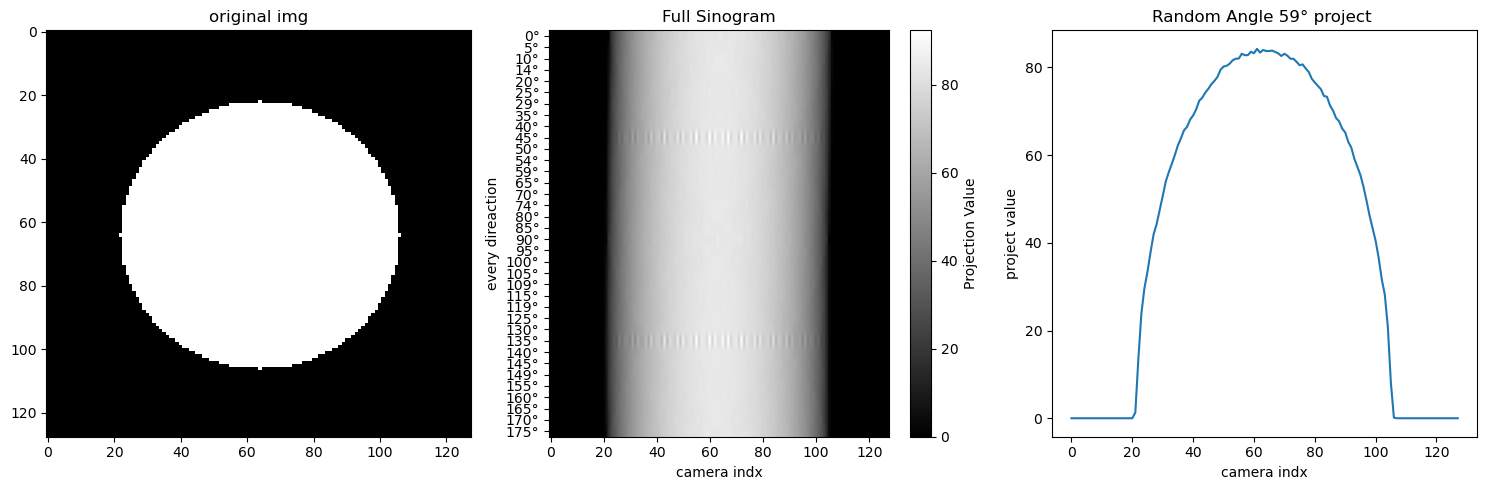

In [11]:
size = 128
n_dir = 36
original_img = generate_synthetic_shape_data(size, shape='circle')
original_img_flat = original_img.ravel()

# ( n_dir *size(投影x索引) ,size**2(网格索引) ) * (size**2) 即对网格点进行加权累积到投影x上
g = build_project_operator(size,n_dir).dot(original_img_flat)
# 每一行表示一个角度 下的投影
sinogram = g.reshape(n_dir, size)
#print(sinogram) # 就是把这些sinogram值通过colorbar绘制到像素图上
visualize_project(original_img, sinogram)

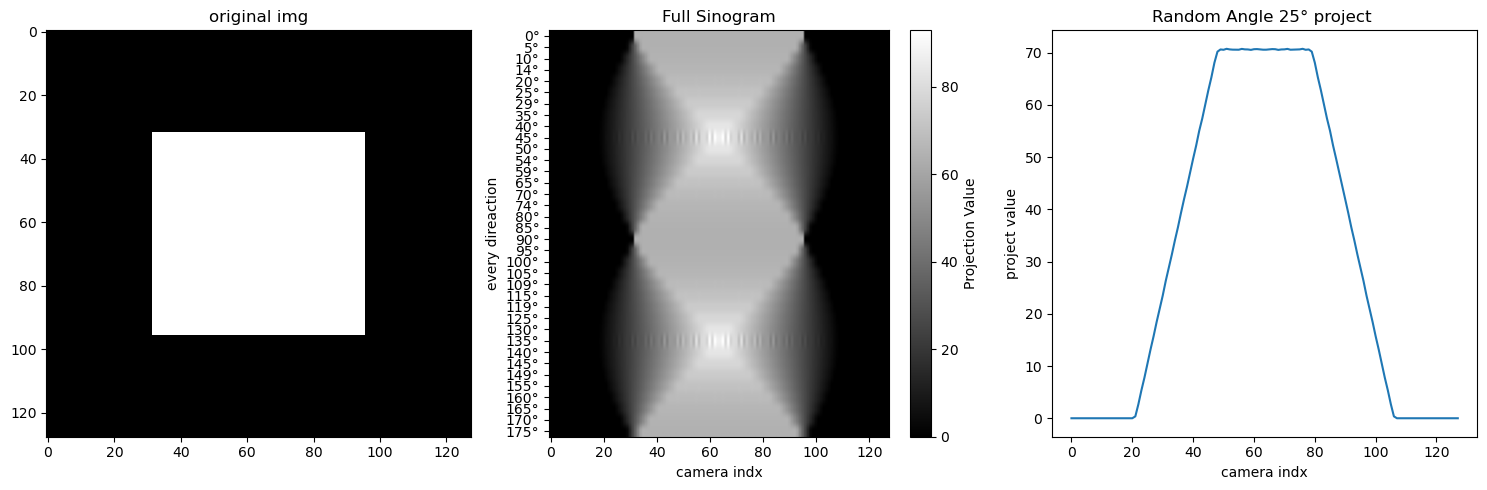

In [15]:
size = 128
n_dir = 36
original_img = generate_synthetic_shape_data(size, shape='square')
original_img_flat = original_img.ravel()

# ( n_dir *size(投影x索引) ,size**2(网格索引) ) * (size**2) 即对网格点进行加权累积到投影x上
g = build_project_operator(size,n_dir).dot(original_img_flat)
# 每一行表示一个角度 下的投影
sinogram = g.reshape(n_dir, size)
#print(sinogram) # 就是把这些sinogram值通过colorbar绘制到像素图上
visualize_project(original_img, sinogram)

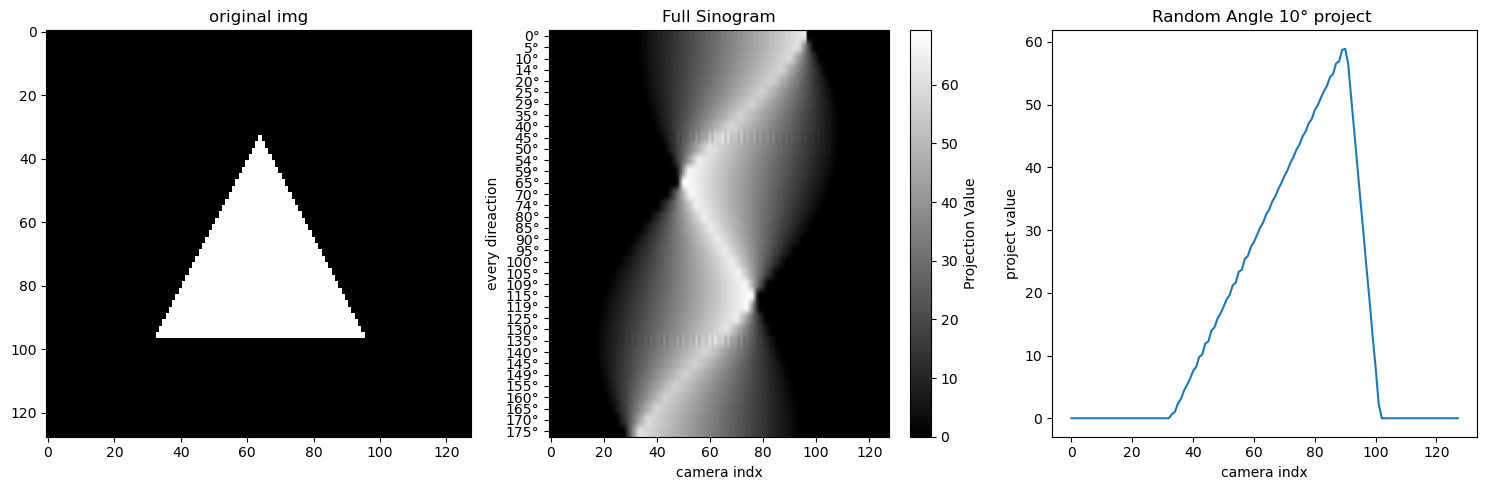

In [12]:
size = 128
n_dir = 36
original_img = generate_synthetic_shape_data(size, shape='triangle')
original_img_flat = original_img.ravel()

# ( n_dir *size(投影x索引) ,size**2(网格索引) ) * (size**2) 即对网格点进行加权累积到投影x上
g = build_project_operator(size,n_dir).dot(original_img_flat)
# 每一行表示一个角度 下的投影
sinogram = g.reshape(n_dir, size)
#print(sinogram) # 就是把这些sinogram值通过colorbar绘制到像素图上
visualize_project(original_img, sinogram)

### 2. 其他图形

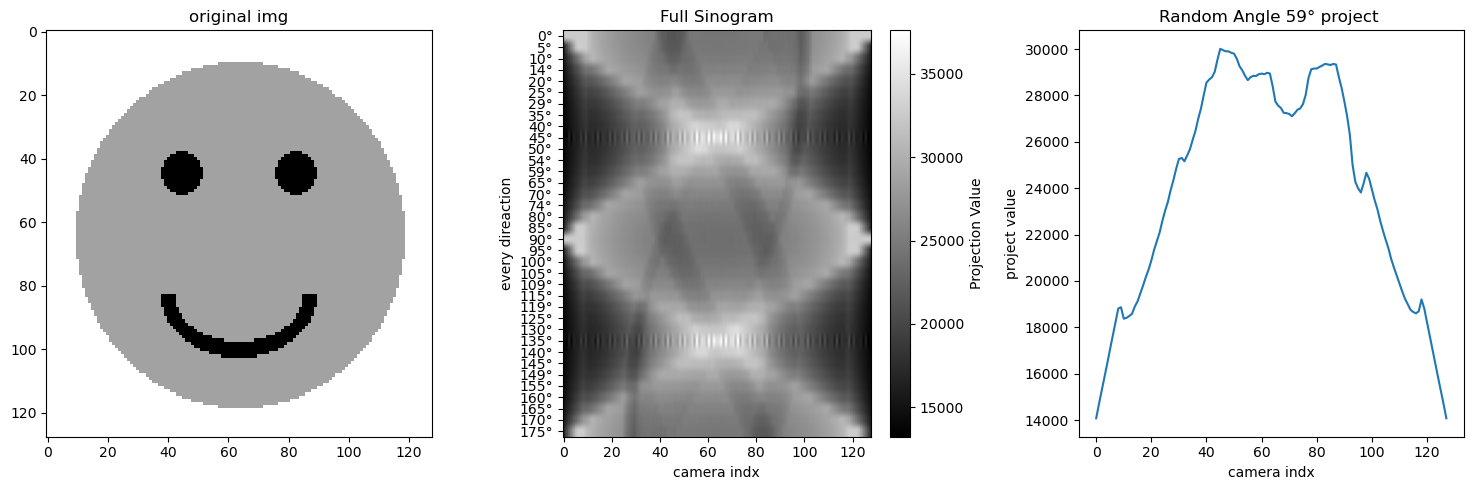

In [13]:
size = 128
n_dir = 36
original_img = generate_smiley(size)
original_img_flat = original_img.ravel()

# ( n_dir *size(投影x索引) ,size**2(网格索引) ) * (size**2) 即对网格点进行加权累积到投影x上
g = build_project_operator(size,n_dir).dot(original_img_flat)
# 每一行表示一个角度 下的投影
sinogram = g.reshape(n_dir, size)
#print(sinogram) # 就是把这些sinogram值通过colorbar绘制到像素图上
visualize_project(original_img, sinogram)

### 3. 边缘

# 4. 重建

**CT:**  
$$
g = A x
$$
 
- $ x $ orignal img，  
- $ A $ project operator，  
- $  g $ sinogram。

**CT restruction**:  $g,A -> x (1D->2D) $But, A is uninversible.

**Lasso**

$$
\hat{x} = \arg\min_x \| A x - g \|_2^2 + \lambda \| x \|_1
$$



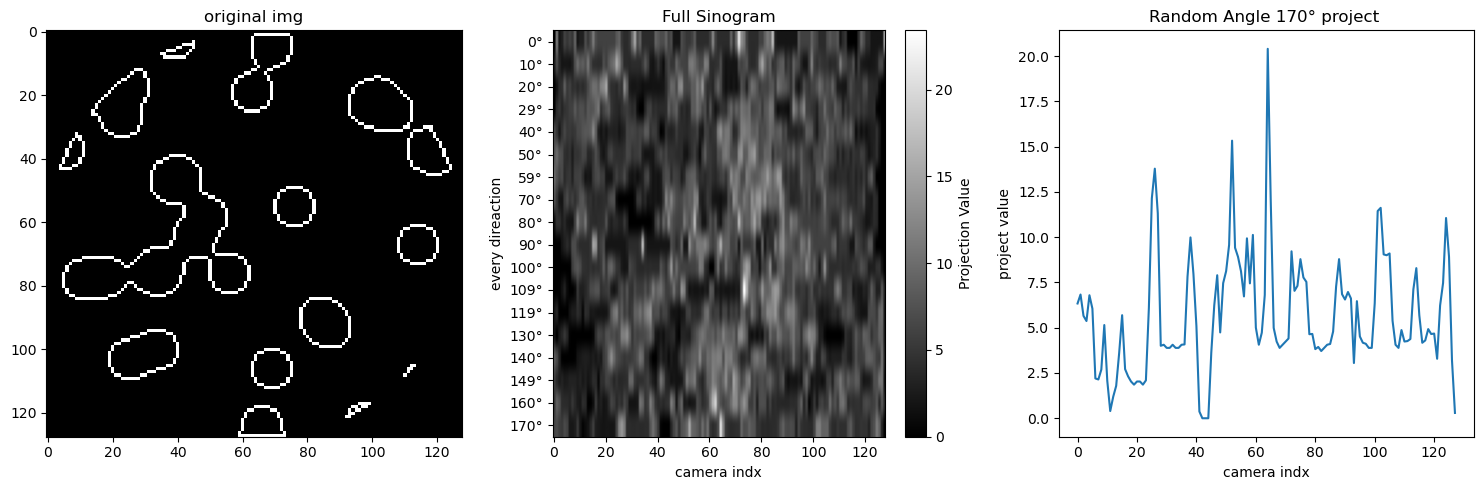

In [26]:
size = 128
n_dir = size//7
original_img = generate_synthetic_data(size)
original_img_flat = original_img.ravel()
operator = build_project_operator(size, n_dir)
g = operator.dot(original_img_flat)
sinogram = g.reshape(n_dir, size)
visualize_project(original_img, sinogram)

In [57]:
# noise
sinogram += 0.15 * np.random.randn(*sinogram.shape) 

In [58]:
print(operator.shape, sinogram.ravel().shape)

(2304, 16384) (2304,)


In [59]:
from sklearn.linear_model import LassoCV
alphas = np.logspace(-3, 3, 50)  # 从 10^-3 到 10^3 取 50 个值
regressor_lasso = LassoCV(alphas=alphas)
regressor_lasso.fit(operator, sinogram.ravel())
regressor_lasso_img = regressor_lasso.coef_.reshape(size, size)

In [60]:
from sklearn.linear_model import RidgeCV
regressor_ridge = RidgeCV(alphas=alphas)
regressor_ridge.fit(operator, sinogram.ravel())
regressor_ridge_img = regressor_ridge.coef_.reshape(size, size)

In [61]:
regressor_lasso.alpha_

np.float64(0.001)

Text(0.5, 1.0, 'Ridge L2 \\alpha 0.21209508879201905')

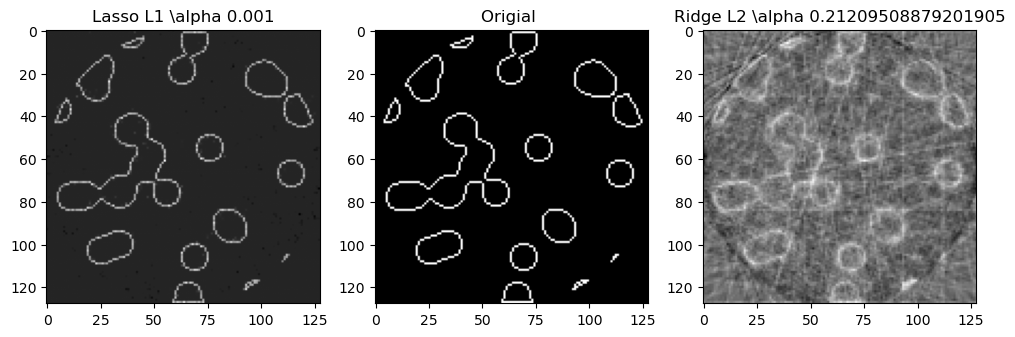

In [62]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(regressor_lasso_img, cmap='gray')
plt.title(f"Lasso L1 \\alpha {regressor_lasso.alpha_}")
plt.subplot(1,3,2)
plt.imshow(original_img,cmap='gray')
plt.title('Origial ')
plt.subplot(1,3,3)
plt.imshow(regressor_ridge_img, cmap='gray')
plt.title(f"Ridge L2 \\alpha {regressor_ridge.alpha_}")